EDA:
BMI: Body Mass Index

| BMI           | Category   |
|--------------:|------------|
|  < 18.5       | Underweight|
| 18.5 - 24.9   | Normal     |
| 25.0 - 29.9   | Overweight |
|  ≥ 30.0       | Obese      |



In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import neighbors
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import random

seed_value = 42

np.random.seed(seed_value)

random.seed(seed_value)

from warnings import filterwarnings
filterwarnings('ignore')


In [3]:
df=pd.read_csv('./Life expectancy.csv')
df.drop(['Country'],axis=1,inplace=True)

In [4]:
df.shape

(124, 17)

In [5]:
df.columns=['Status', 'Adult_Mortality', 'Infant_Deaths', 'Hepatitis', 'Measles', 'BMI', 'Underfive_Deaths', 'Polio', 'Diphtheria', 'HIV', 'GDP', 'Population', 'Malnourished10_19', 'Malnourished5_9', 'Income_Index', 'Schooling', 'Expected']


In [6]:
df.head()

,Status,Adult_Mortality,Infant_Deaths,Hepatitis,Measles,BMI,Underfive_Deaths,Polio,Diphtheria,HIV,GDP,Population,Malnourished10_19,Malnourished5_9,Income_Index,Schooling,Expected
0,Developing,263,62.0,65.0,1154,19.1,NaN,6,65,0.1,584.259210,33736494,17.2,17.3,0.479,NaN,65.0
1,Developing,8,0.0,98.0,0,57.2,NaN,98,98,0.1,4575.763787,288914,1.2,1.3,0.761,14.2,77.5
2,Developing,19,21.0,95.0,63,59.5,NaN,95,95,0.1,4132.762920,39871528,6.0,5.8,0.743,14.4,75.6
3,Developing,335,66.0,64.0,118,23.3,NaN,7,64,1.9,3695.793748,2785935,8.3,8.2,0.531,11.4,52.4
4,Developing,116,8.0,94.0,0,62.8,NaN,93,94,0.1,13467.123600,43417765,1.0,0.9,0.826,17.3,76.3


In [7]:
np.mean(df.Expected)

71.2209677419355

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Adult_Mortality,124.0,1.604758e+02,1.017945e+02,3.000000,73.500000,1.395000e+02,2.340000e+02,4.380000e+02
Infant_Deaths,110.0,2.854545e+01,1.001563e+02,0.000000,0.000000,4.000000e+00,1.975000e+01,9.100000e+02
Hepatitis,119.0,8.759664e+01,2.457859e+01,6.000000,85.000000,9.400000e+01,9.750000e+01,1.980000e+02
Measles,124.0,2.841637e+03,1.151759e+04,0.000000,0.750000,3.700000e+01,5.887500e+02,9.038700e+04
BMI,124.0,4.173387e+01,2.118638e+01,2.100000,20.950000,5.410000e+01,5.975000e+01,7.140000e+01
Underfive_Deaths,119.0,4.395798e+01,1.587556e+02,0.000000,1.000000,7.000000e+00,2.350000e+01,1.110000e+03
Polio,124.0,8.663710e+01,2.165334e+01,6.000000,88.000000,9.500000e+01,9.800000e+01,9.900000e+01
Diphtheria,124.0,8.791935e+01,1.912288e+01,6.000000,89.000000,9.500000e+01,9.800000e+01,9.900000e+01
HIV,124.0,8.193548e-01,1.764127e+00,0.100000,0.100000,1.000000e-01,4.000000e-01,8.100000e+00
GDP,124.0,6.866817e+03,1.088524e+04,5.668726,639.799727,2.728292e+03,8.437563e+03,5.655439e+04


### Outlier Identifiaction and removal using z-score

In [9]:
def find_outlier_z_score(features,df):
    summary_outliers_df=pd.DataFrame()
    summary_outliers_data = {'Feature_Name':[],'Count_Outliers':[],'Percentage_Outliers':[]}
    feature_outliers_df = pd.DataFrame()
    for feature in features:
        z_scores = st.zscore(df[feature])
        threshold = 3
        outliers_mask = (np.absolute(z_scores)>threshold)
        outliers_indices = np.column_stack(np.where(outliers_mask))
        feature_outliers_df = df.iloc[outliers_indices[:, 0]]
        summary_outliers_data['Feature_Name'].append(feature)
        summary_outliers_data['Count_Outliers'].append(feature_outliers_df.shape[0])
        summary_outliers_data['Percentage_Outliers'].append(np.round((feature_outliers_df.shape[0]/df[feature].shape[0])*100,2))
        summary_outliers_df=pd.DataFrame(summary_outliers_data)
        summary_outliers_df
    summary_outliers_df=summary_outliers_df[summary_outliers_df['Count_Outliers'] !=0]
    summary_outliers_df.sort_values(by='Count_Outliers',ascending=False,inplace=True)
    return summary_outliers_df
def remove_outlier(feature,df):
    z_scores = st.zscore(df[feature])
    threshold = 3
    outliers_mask = (np.absolute(z_scores)>threshold)
    outliers_indices = np.column_stack(np.where(outliers_mask))
    feature_outliers_df = df.iloc[outliers_indices[:, 0]]
    return df[~df[feature].isin(feature_outliers_df[feature])]

In [10]:
features = df.columns.to_list()[1:]
summary_outliers_df=find_outlier_z_score(features,df=df.iloc[:,1:])

In [11]:
summary_outliers_df

,Feature_Name,Count_Outliers,Percentage_Outliers
10,Population,8,6.45
6,Polio,6,4.84
8,HIV,6,4.84
9,GDP,5,4.03
3,Measles,4,3.23
7,Diphtheria,4,3.23
11,Malnourished10_19,3,2.42
12,Malnourished5_9,3,2.42


In [12]:
df_outlier_removed=remove_outlier('Population',df)

### Finding Missing Values

In [13]:
def find_missing_values():
    percentage_missing=pd.Series(round((df.isnull().sum()/df.shape[0])*100,2),name='percentage of missing lines')
    total_missing=pd.Series(df.isnull().sum(),name='Total Missing Lines')
    missing_values=pd.concat([total_missing,percentage_missing],axis=1)
    missing_values.rename({0:'Total Missing Data Points',1:'Percentage of Missing Data points'},inplace=True)
    return missing_values[missing_values['Total Missing Lines'] !=0]

In [14]:
find_missing_values()

,Total Missing Lines,percentage of missing lines
Infant_Deaths,14,11.29
Hepatitis,5,4.03
Underfive_Deaths,5,4.03
Income_Index,3,2.42
Schooling,5,4.03


### Missing Value Impotation: Mean

In [15]:
MissingValue_Features = ['Infant_Deaths', 'Hepatitis', 'Underfive_Deaths', 'Income_Index','Schooling']
for feature in MissingValue_Features:
    df[feature].fillna(np.mean(df[feature]),inplace=True)

In [16]:
find_missing_values()

,Total Missing Lines,percentage of missing lines


### EDA

<Axes: xlabel='Expected', ylabel='GDP'>

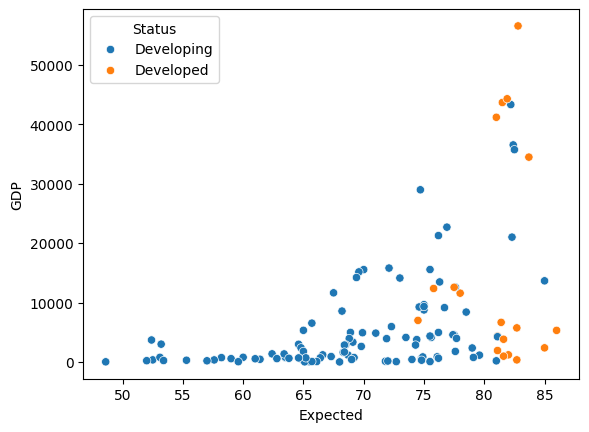

In [17]:
sns.scatterplot(data=df,x='Expected',y='GDP',hue='Status')

1. All the Developed countries are having more life expectancy
2. Countries with less than average GDP are having less life expectancy

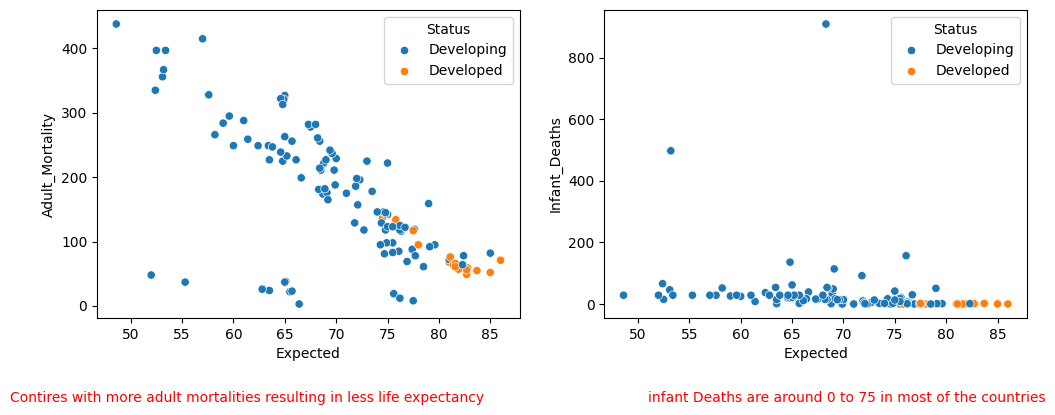

In [18]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(data=df,x='Expected',y='Adult_Mortality',hue='Status',ax=axes[0])
fig.text(0.25, -0.1, "Contires with more adult mortalities resulting in less life expectancy", fontsize=10, color='red', ha='center')
sns.scatterplot(data=df,x='Expected',y='Infant_Deaths',hue='Status',ax=axes[1])
fig.text(0.75, -0.1, "infant Deaths are around 0 to 75 in most of the countries", fontsize=10, color='red', ha='center')
plt.show()


<b>Inferences:</b>
1. The more of adult mortalities resulting in less life expectancy
2. Adult mortality rate is less than average in the Developed countries

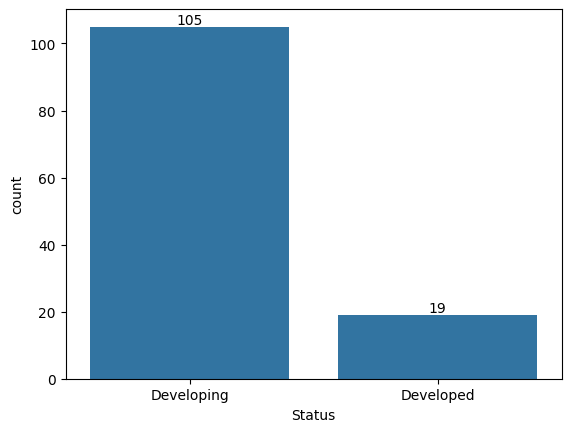

In [19]:
ax=sns.countplot(data=df,x='Status',stat='count')
for label in ax.containers:
    ax.bar_label(label)
plt.show()

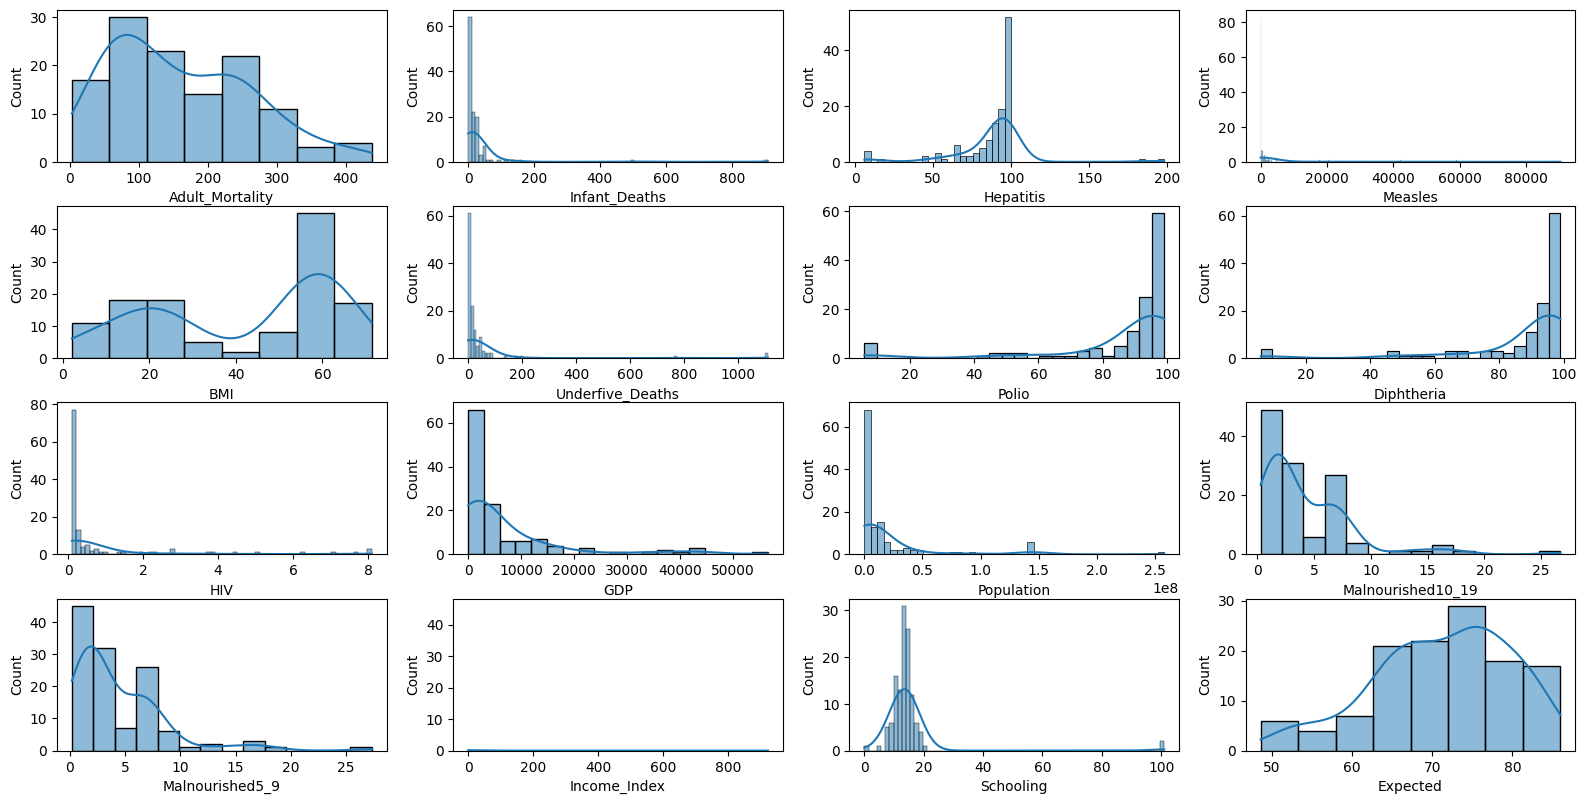

In [20]:
fig,axes=plt.subplots(4,4,figsize=(16,8))
plt.tight_layout()
features=df.columns.to_list()[1:]
# features=['Adult_Mortality', 'Infant_Deaths','Hepatitis ','Measles ']
total_features=len(features)
i=0
for r in range(4):
    for c in range(4):
        if i < total_features:
            # print(r,c,features[i])
            sns.histplot(data=df,x=features[i],kde=True,ax=axes[r,c])
            i+=1

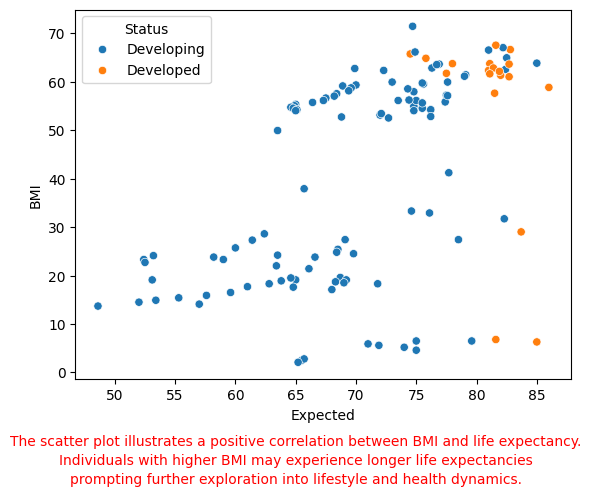

In [105]:
sns.scatterplot(data=df, x='Expected', y='BMI', hue='Status')
plt.text(65, -15, "The scatter plot illustrates a positive correlation between BMI and life expectancy.", fontsize=10, color='red', ha='center')
plt.text(65, -19, "Individuals with higher BMI may experience longer life expectancies", fontsize=10, color='red', ha='center')
plt.text(65, -23, "prompting further exploration into lifestyle and health dynamics.", fontsize=10, color='red', ha='center')
plt.show()

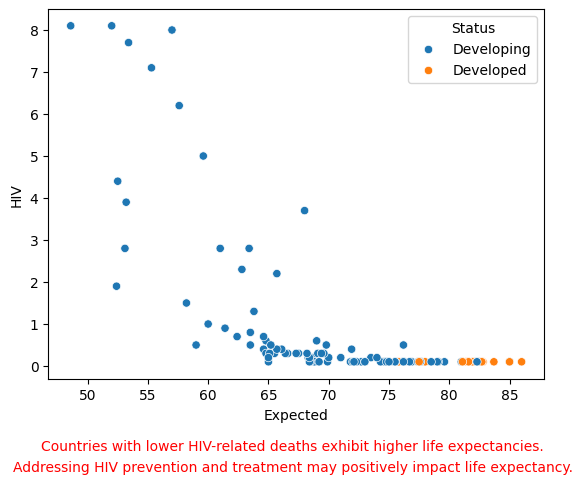

In [99]:
sns.scatterplot(data=df, x='Expected', y='HIV', hue='Status')
plt.text(67, -2, "Countries with lower HIV-related deaths exhibit higher life expectancies.", fontsize=10, color='red', ha='center')
plt.text(67, -2.5, "Addressing HIV prevention and treatment may positively impact life expectancy.", fontsize=10, color='red', ha='center')
plt.show()

### Scaling the Data

In [23]:
from sklearn.preprocessing import StandardScaler
scaler_obj = StandardScaler()
df_numeric_columns=df.iloc[:,1:].columns
df_numeric_scaled = scaler_obj.fit_transform(df.iloc[:,1:])
df_numeric_scaled = pd.DataFrame(df_numeric_scaled,columns=df_numeric_columns)

df_numeric_scaled.head()

,Adult_Mortality,Infant_Deaths,Hepatitis,Measles,BMI,Underfive_Deaths,Polio,Diphtheria,HIV,GDP,Population,Malnourished10_19,Malnourished5_9,Income_Index,Schooling,Expected
0,1.011254,0.356266,-0.942447,-0.147121,-1.072655,-4.588081e-17,-3.739110,-1.203393,-0.409423,-0.579504,0.345979,3.198683,3.080864,-0.132816,0.000000,-0.737631
1,-1.503955,-0.303988,0.433897,-0.247722,0.732965,-4.588081e-17,0.526893,0.529290,-0.409423,-0.211327,-0.472973,-0.732305,-0.732496,-0.130383,-0.041341,0.744516
2,-1.395456,-0.080354,0.308775,-0.242230,0.841965,-4.588081e-17,0.387784,0.371773,-0.409423,-0.252190,0.496193,0.446991,0.340012,-0.130538,-0.023771,0.519230
3,1.721431,0.398863,-0.984154,-0.237436,-0.873611,-4.588081e-17,-3.692740,-1.255898,0.615052,-0.292496,-0.411834,1.012071,0.912016,-0.132367,-0.287319,-2.231636
4,-0.438690,-0.218794,0.267067,-0.247722,0.998358,-4.588081e-17,0.295045,0.319267,-0.409423,0.608814,0.583022,-0.781442,-0.827830,-0.129822,0.230992,0.602230


### Correlation Anaylysis

In [24]:
df_features = df_numeric_scaled.drop(['Expected'],axis=1)
df_target = df_numeric_scaled['Expected']

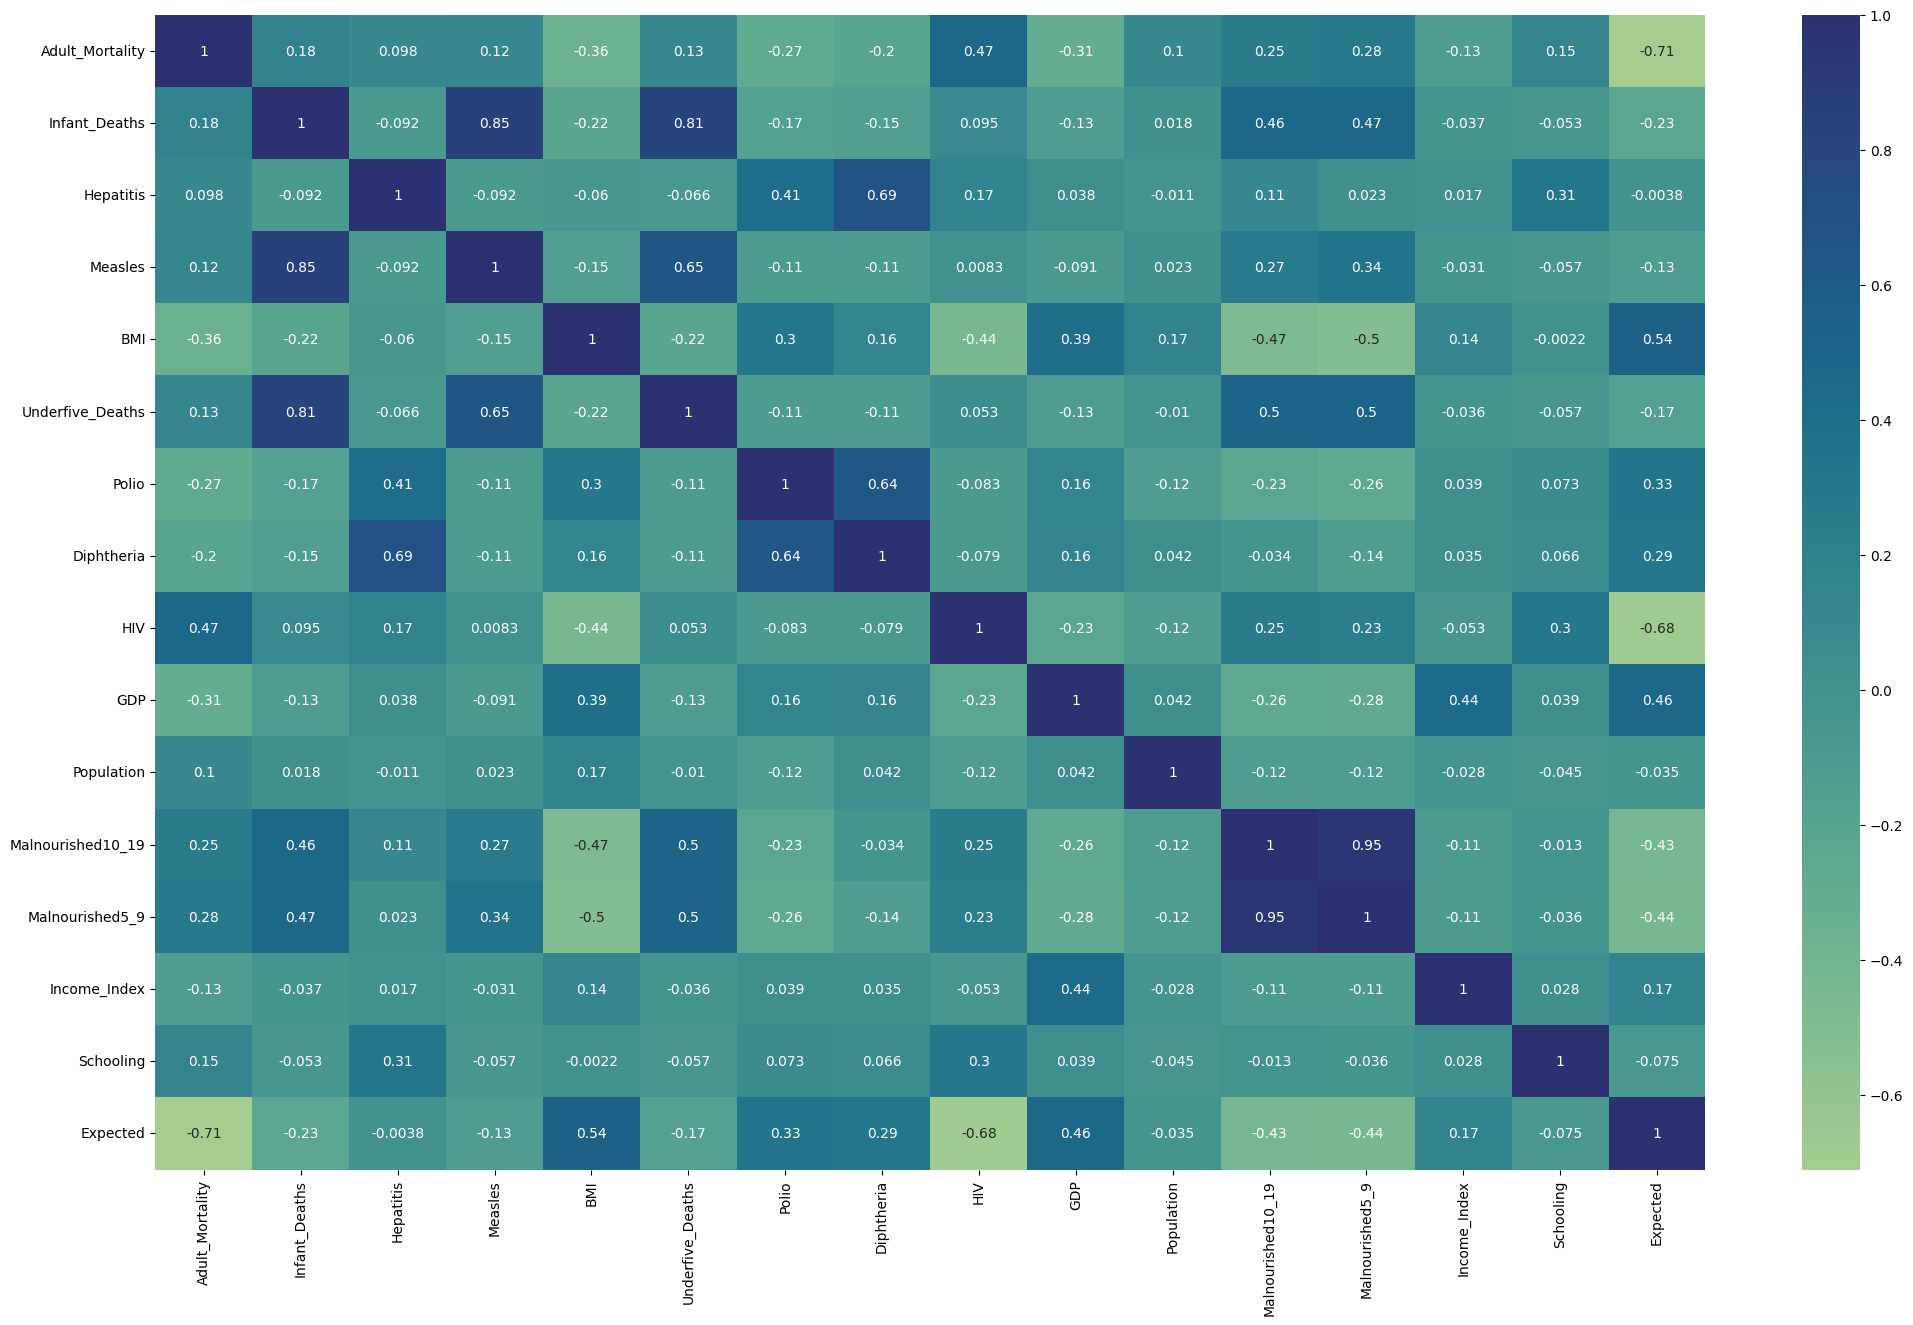

In [80]:
plt.figure(figsize=(25,15))
sns.heatmap(df.iloc[:,1:].corr(),annot=True,fmt=".2g",cmap='crest')
plt.show()

<Axes: >

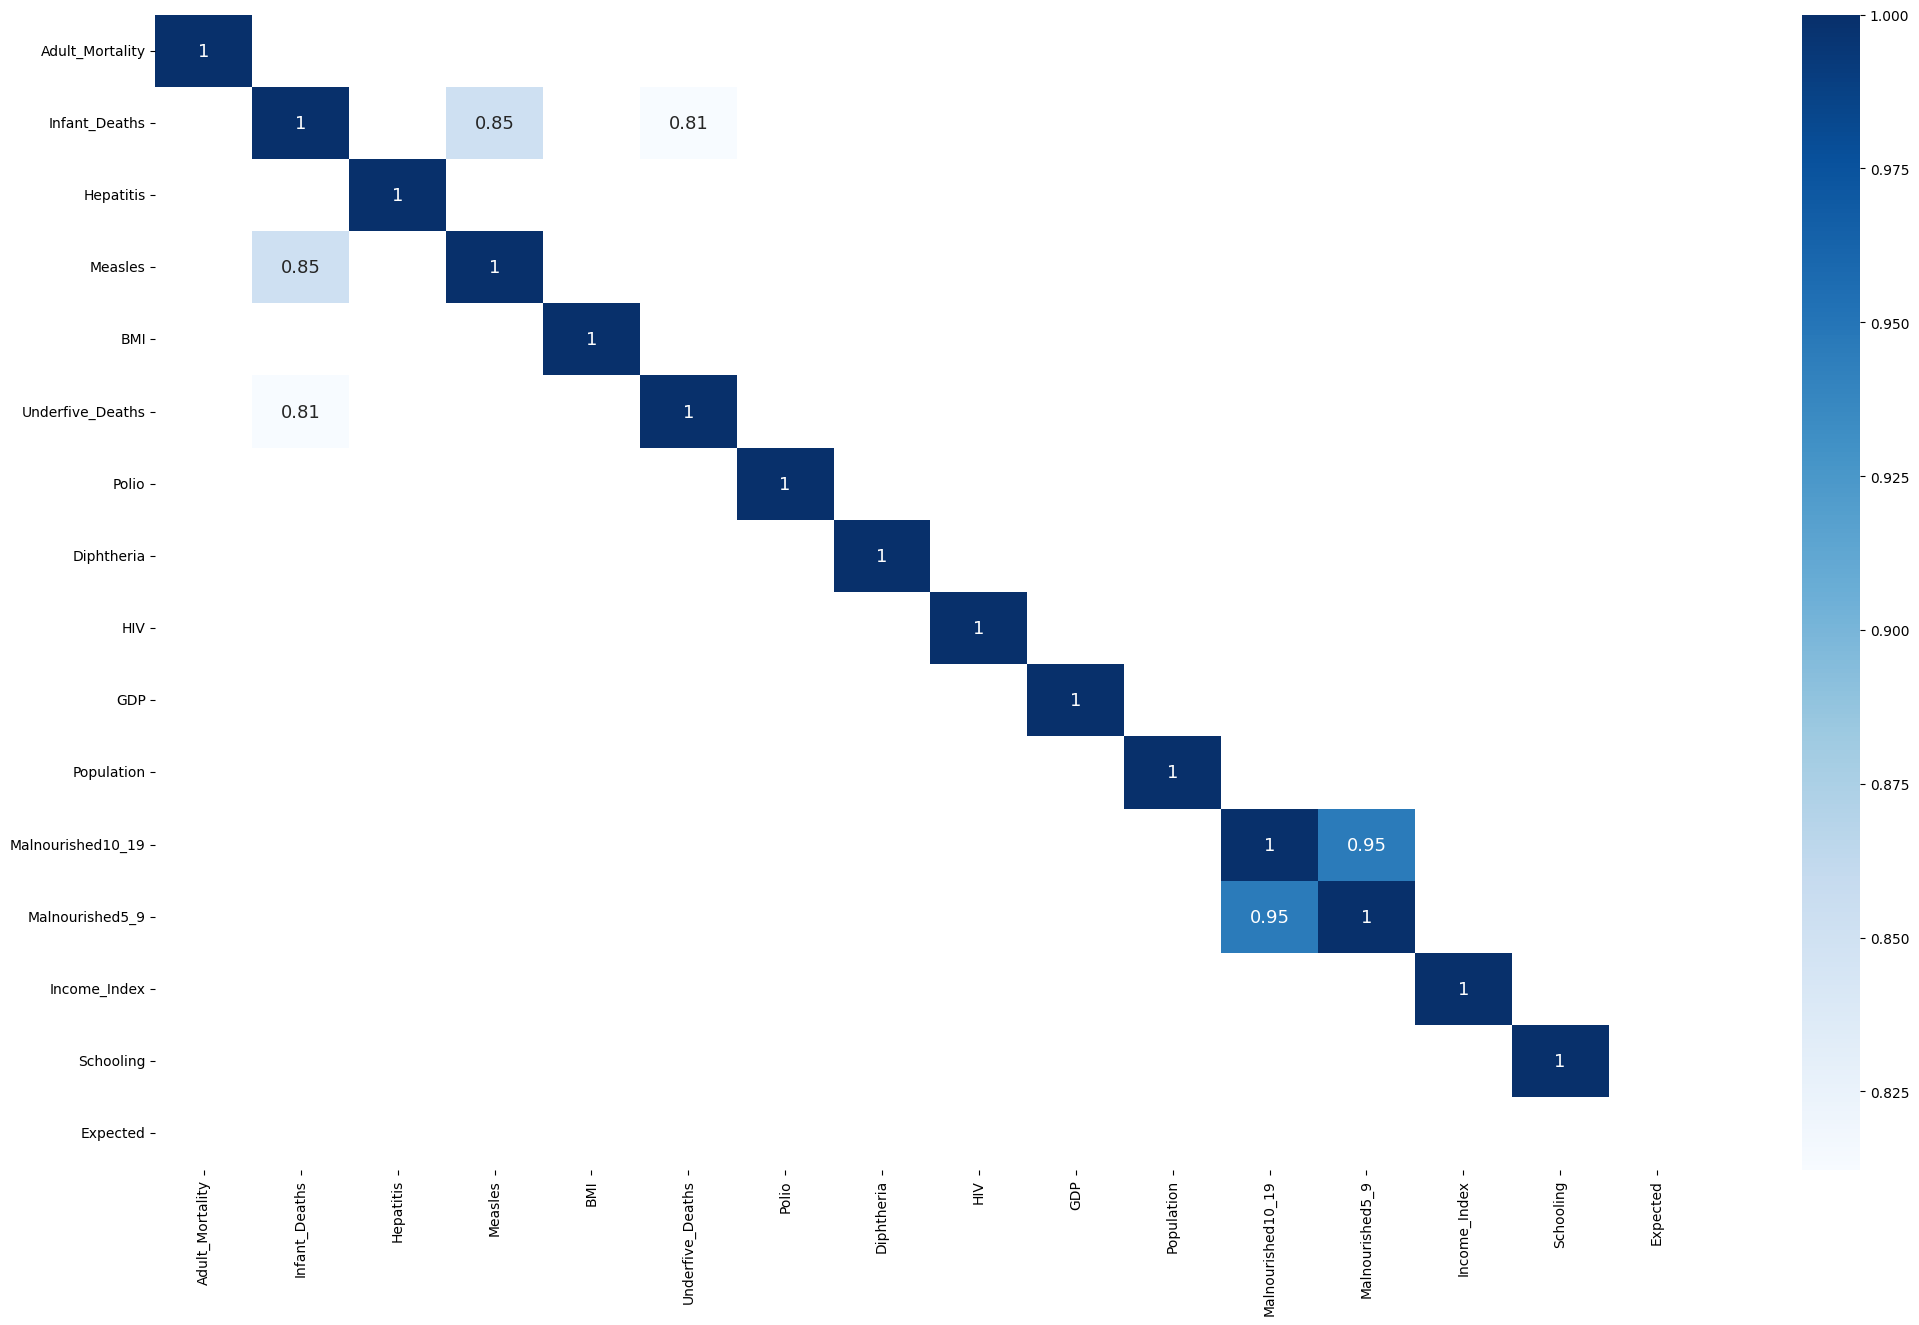

In [82]:
plt.figure(figsize=(25,15))
sns.heatmap(df.iloc[:,1:].corr()[np.abs(df_features.corr()) > 0.8], annot = True, annot_kws = {"size": 13}, cmap = 'Blues')

### Variance Inflation Factor (VIF)

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [28]:
def get_vif(X):
    vif= pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['Features'] = X.columns
    vif=vif.sort_values(by='VIF_Factor',ascending=False).reset_index(drop=True)
    return vif

In [29]:
get_vif(df_numeric_scaled)

,VIF_Factor,Features
0,14.420805,Malnourished10_19
1,13.537113,Malnourished5_9
2,7.589070,Infant_Deaths
3,4.712845,Measles
4,4.445146,Expected
5,3.385983,Diphtheria
6,3.235327,Underfive_Deaths
7,2.487875,Hepatitis
8,2.424144,HIV
9,2.231290,Adult_Mortality


In [30]:
#dropping Malnourished10_19 which has the high correlation
get_vif(df_numeric_scaled.drop(['Malnourished10_19'],axis=1))

,VIF_Factor,Features
0,6.654813,Infant_Deaths
1,4.372346,Expected
2,3.831447,Measles
3,3.233666,Underfive_Deaths
4,3.103472,Diphtheria
5,2.469625,Hepatitis
6,2.423970,HIV
7,2.181382,Adult_Mortality
8,2.030823,Polio
9,1.947199,Malnourished5_9


In [31]:
#Creating a copy of the data set for removing multi-collinerialty using VIF
df_vif_copy_numeric=df_numeric_scaled.copy()

In [32]:
#creating an interaction varaible called malnuirshed and then caluculating the VIF
df_vif_copy_numeric['Malnourished'] = df_vif_copy_numeric.apply(lambda x: x['Malnourished10_19'] + x['Malnourished5_9'],axis=1)
get_vif(df_vif_copy_numeric.drop(['Malnourished10_19','Malnourished5_9'],axis=1))

,VIF_Factor,Features
0,6.780077,Infant_Deaths
1,4.417164,Expected
2,3.908574,Measles
3,3.233576,Underfive_Deaths
4,3.132162,Diphtheria
5,2.475274,Hepatitis
6,2.421029,HIV
7,2.192046,Adult_Mortality
8,2.056241,Polio
9,2.030906,Malnourished


In [33]:
#creating an interaction varaible called Child Deaths which is the summation of Infanct Deaths and Underfive_Deaths and then caluculating the VIF
df_vif_copy_numeric['Child_deaths'] = df_vif_copy_numeric.apply(lambda x: x['Infant_Deaths'] + x['Underfive_Deaths'],axis=1)
get_vif(df_vif_copy_numeric.drop(['Infant_Deaths','Underfive_Deaths','Malnourished10_19','Malnourished5_9'],axis=1))

,VIF_Factor,Features
0,4.405507,Expected
1,3.473392,Child_deaths
2,3.130558,Diphtheria
3,2.789274,Measles
4,2.474971,Hepatitis
5,2.409099,HIV
6,2.192041,Adult_Mortality
7,2.042642,Polio
8,2.030896,Malnourished
9,1.834296,BMI


In [34]:
#Because the VIF for all the features are reduced to less than 5
#Removing all the unneccsary columns from the Dataset
df_vif_copy_numeric.drop(['Infant_Deaths','Underfive_Deaths','Malnourished10_19','Malnourished5_9'],axis=1,inplace=True)

In [35]:
df_vif_copy_numeric

,Adult_Mortality,Hepatitis,Measles,BMI,Polio,Diphtheria,HIV,GDP,Population,Income_Index,Schooling,Expected,Malnourished,Child_deaths
0,1.011254,-0.942447,-0.147121,-1.072655,-3.739110,-1.203393,-0.409423,-0.579504,0.345979,-0.132816,0.000000,-0.737631,6.279546,0.356266
1,-1.503955,0.433897,-0.247722,0.732965,0.526893,0.529290,-0.409423,-0.211327,-0.472973,-0.130383,-0.041341,0.744516,-1.464801,-0.303988
2,-1.395456,0.308775,-0.242230,0.841965,0.387784,0.371773,-0.409423,-0.252190,0.496193,-0.130538,-0.023771,0.519230,0.787003,-0.080354
3,1.721431,-0.984154,-0.237436,-0.873611,-3.692740,-1.255898,0.615052,-0.292496,-0.411834,-0.132367,-0.287319,-2.231636,1.924086,0.398863
4,-0.438690,0.267067,-0.247722,0.998358,0.295045,0.319267,-0.409423,0.608814,0.583022,-0.129822,0.230992,0.602230,-1.609272,-0.218794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-1.217912,0.308775,-0.236477,-1.248004,0.387784,0.371773,3.574644,-0.606837,-0.259887,-0.133601,-0.515727,-1.887777,1.269554,-0.283843
120,2.332972,0.058531,-0.214073,-1.271700,0.109567,0.056740,3.916135,-0.611544,-0.264130,-0.133747,-0.568436,-2.113064,1.317957,-0.283843
121,-1.109413,0.350482,-0.154967,-1.290657,0.434154,0.424279,4.143796,-0.613780,-0.458786,-0.133851,-0.621146,-2.279064,1.390192,0.013186
122,2.510516,0.016823,-0.009035,-1.309614,-0.075912,0.004234,4.086881,-0.615262,-0.459146,-0.133989,-0.656285,-1.686205,1.463163,0.039014


### Encoding the categorical column

In [36]:
df_cat_features=df.iloc[:,0]


In [37]:
df_cat_features_encoded=pd.get_dummies(df_cat_features)

### Preparing the features for model traning and testing

In [38]:
columns = ['Model Name', 'R2-score', 'MSE' , 'MAE']
model_summary_stats = pd.DataFrame(columns=columns)
def UpdateSummaryTable(model_name,r_sq,mse,mae):
    global model_summary_stats
    new_row = pd.DataFrame([[model_name,r_sq,mse,mae]],columns=columns)
    model_summary_stats=pd.concat([model_summary_stats,new_row])
    return model_summary_stats

In [39]:
#Concat the categorical and numeric coumns
df_final_scaled_encoded = pd.concat([df_cat_features_encoded,df_vif_copy_numeric],axis=1)

In [40]:
df_final_scaled_encoded.head(3)

,Developed,Developing,Adult_Mortality,Hepatitis,Measles,BMI,Polio,Diphtheria,HIV,GDP,Population,Income_Index,Schooling,Expected,Malnourished,Child_deaths
0,False,True,1.011254,-0.942447,-0.147121,-1.072655,-3.739110,-1.203393,-0.409423,-0.579504,0.345979,-0.132816,0.000000,-0.737631,6.279546,0.356266
1,False,True,-1.503955,0.433897,-0.247722,0.732965,0.526893,0.529290,-0.409423,-0.211327,-0.472973,-0.130383,-0.041341,0.744516,-1.464801,-0.303988
2,False,True,-1.395456,0.308775,-0.242230,0.841965,0.387784,0.371773,-0.409423,-0.252190,0.496193,-0.130538,-0.023771,0.519230,0.787003,-0.080354


In [41]:
df_final_scaled_encoded['Developed']=df_final_scaled_encoded['Developed'].astype(int)
df_final_scaled_encoded['Developing']=df_final_scaled_encoded['Developing'].astype(int)

In [42]:
X_full = df_final_scaled_encoded.drop(['Expected'],axis=1)

Y_full = df_final_scaled_encoded['Expected']



X_train,x_test,Y_train,y_test  = train_test_split(X_full,Y_full,random_state=1,test_size=0.3)

print("X_Train:",X_train.shape)
print("Y_Train:",Y_train.shape)
print("X_Test:",x_test.shape)
print("Y_Test:",y_test.shape)

X_Train: (86, 15)
Y_Train: (86,)
X_Test: (38, 15)
Y_Test: (38,)


In [43]:
FUll_MLR_model=sm.OLS(Y_train,X_train).fit()

print(FUll_MLR_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Expected   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     21.21
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           6.04e-20
Time:                        10:53:50   Log-Likelihood:                -52.290
No. Observations:                  86   AIC:                             134.6
Df Residuals:                      71   BIC:                             171.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Developed           0.3920      0.176     

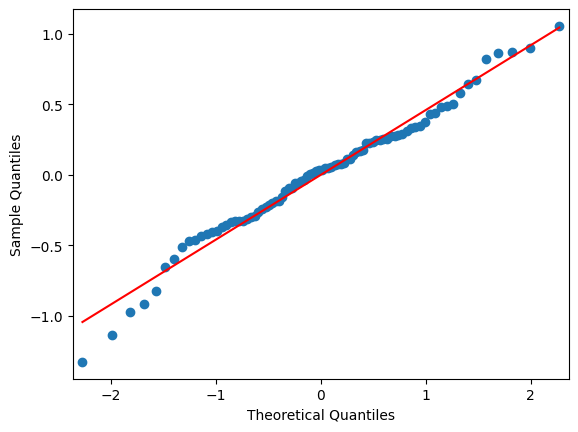

In [44]:
qqplot(FUll_MLR_model.resid,line='r')
plt.show()

In [45]:
full_y_predict=FUll_MLR_model.predict(x_test)
full_mse=mean_squared_error(y_test,full_y_predict)
full_mae=mean_absolute_error(y_test,full_y_predict)
r2 = r2_score(y_test, full_y_predict)

In [46]:
UpdateSummaryTable('Linear Regression Full-Features',r2,full_mse,full_mae)

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332


In [47]:
p_values = FUll_MLR_model.pvalues

alpha = 0.05

p_values[p_values<alpha]

Developed          0.028986
Adult_Mortality    0.000002
HIV                0.000001
dtype: float64

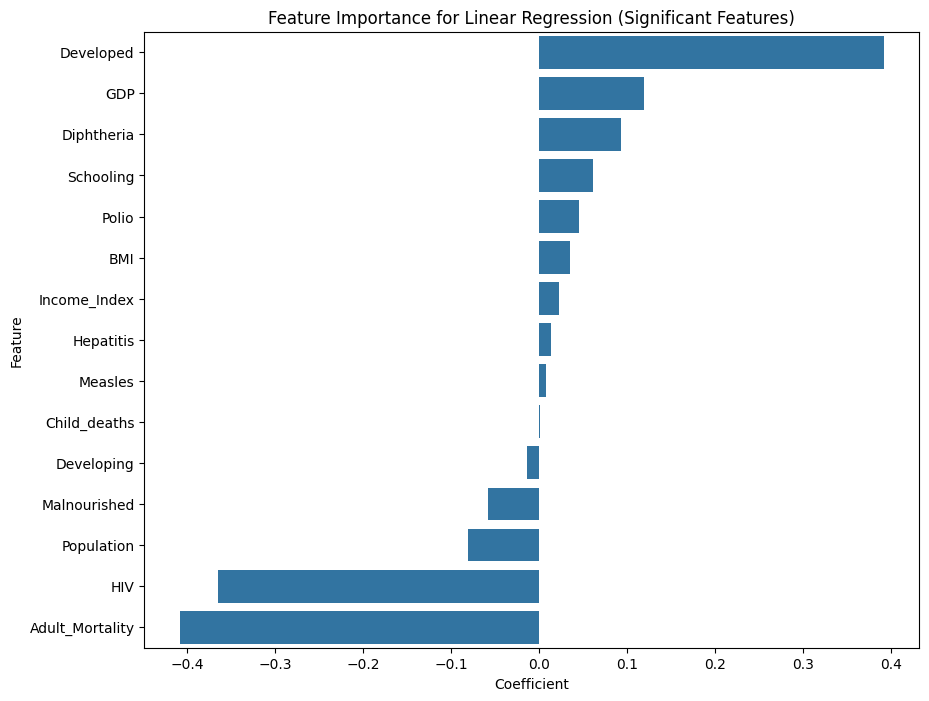

In [138]:
coefficients = FUll_MLR_model.params  # Assuming 'model' is your linear regression model
feature_names = X_full.columns  # Replace with your feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance for Linear Regression (Significant Features)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

In [48]:
variences=df_final_scaled_encoded.var()

threshold =0.1

variences[variences<threshold]

Series([], dtype: float64)

<Axes: >

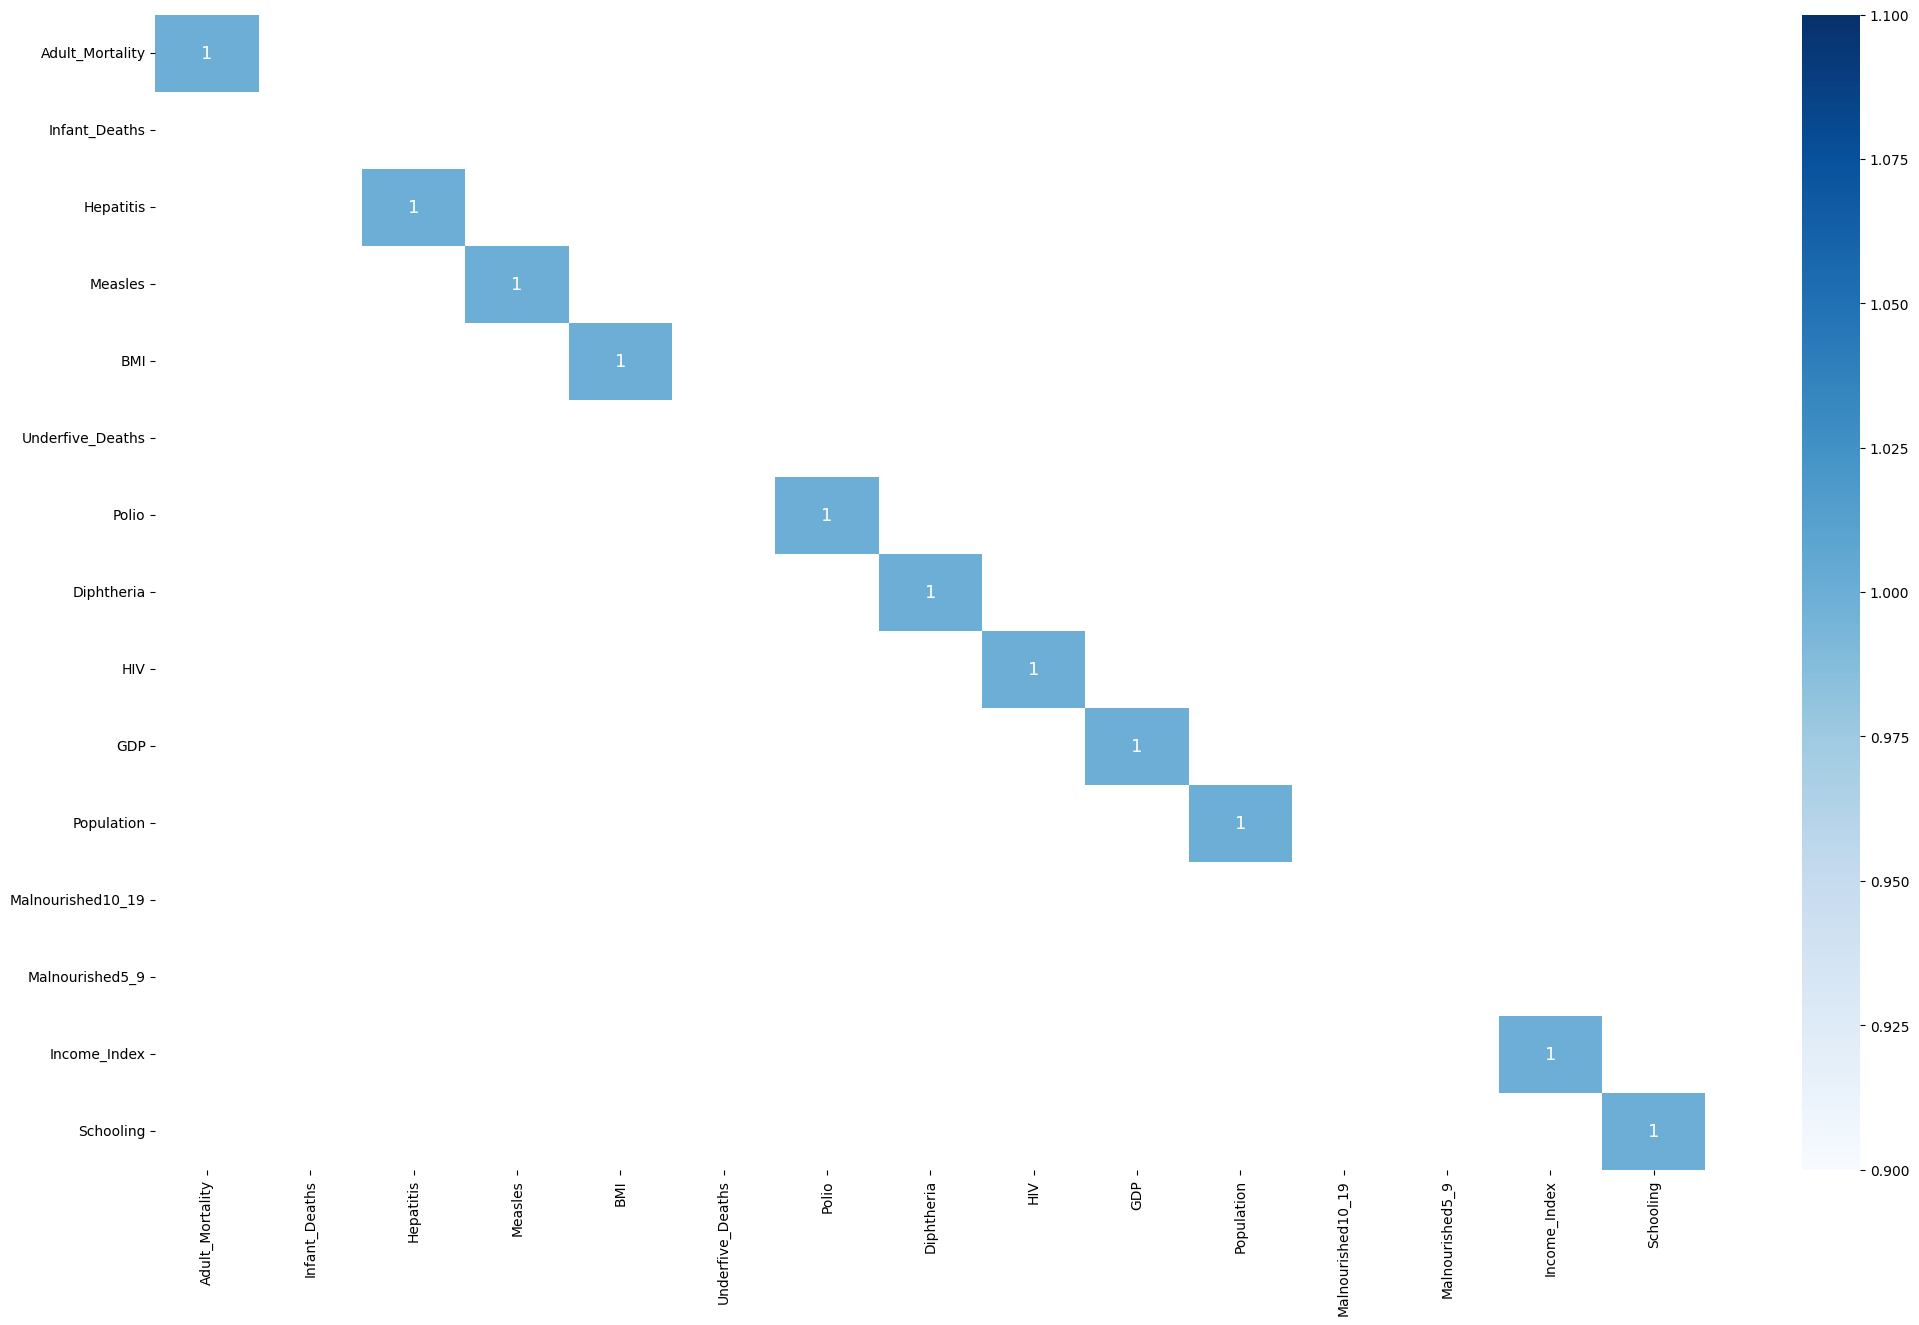

In [49]:
plt.figure(figsize=(25,15))
sns.heatmap(df_features.corr()[np.abs(df_final_scaled_encoded.corr()) > 0.8], annot = True, annot_kws = {"size": 13}, cmap = 'Blues')

In [50]:
model = LinearRegression()

selector = RFECV(model, step=1, cv=5)
selector = selector.fit(X_full, Y_full)
selected_features = X_full.columns[selector.support_]

In [51]:
selected_features

Index(['Developed', 'Developing', 'Adult_Mortality', 'BMI', 'Diphtheria',
       'HIV', 'GDP', 'Schooling'],
      dtype='object')

In [52]:
X_full_significant = df_final_scaled_encoded.loc[:,selected_features]
Y_full_significant = df_final_scaled_encoded['Expected']
X_with_const = sm.add_constant(X_full_significant)



X_train_sign,x_test_sign,Y_train_sign,y_test_sign  = train_test_split(X_with_const,Y_full_significant,random_state=1,test_size=0.3)

print("X_Train:",X_train_sign.shape)
print("Y_Train:",Y_train_sign.shape)
print("X_Test:",x_test_sign.shape)
print("Y_Test:",y_test_sign.shape)

X_Train: (86, 9)
Y_Train: (86,)
X_Test: (38, 9)
Y_Test: (38,)


In [53]:
MLR_model_significant=sm.OLS(Y_train_sign,X_train_sign).fit()

print(MLR_model_significant.summary())

                            OLS Regression Results                            
Dep. Variable:               Expected   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     42.00
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           6.25e-24
Time:                        10:53:52   Log-Likelihood:                -55.857
No. Observations:                  86   AIC:                             127.7
Df Residuals:                      78   BIC:                             147.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1458      0.055     

In [54]:
y_predict_MLR_sig=MLR_model_significant.predict(x_test_sign)
MLR_signf_mse=mean_squared_error(y_test_sign,y_predict_MLR_sig)
MLR_signf_mae=mean_absolute_error(y_test_sign,y_predict_MLR_sig)
r2_MLR_sign = r2_score(y_test_sign, y_predict_MLR_sig)

In [55]:
UpdateSummaryTable('Linear Regression significant-features',r2_MLR_sign,MLR_signf_mse,MLR_signf_mae)

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332
0,Linear Regression significant-features,0.715642,0.269154,0.394276


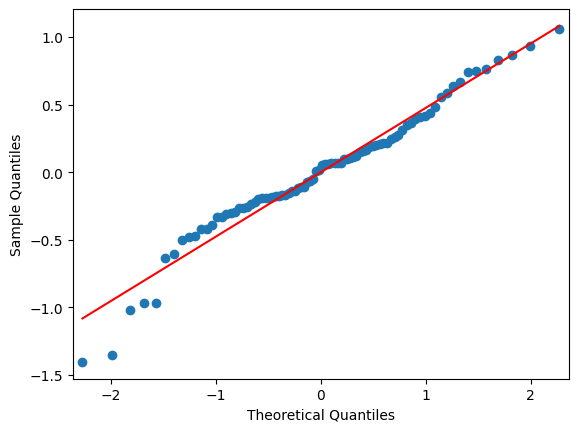

In [56]:
qqplot(MLR_model_significant.resid,line='r')
plt.show()

In [57]:
residuals=MLR_model_significant.resid

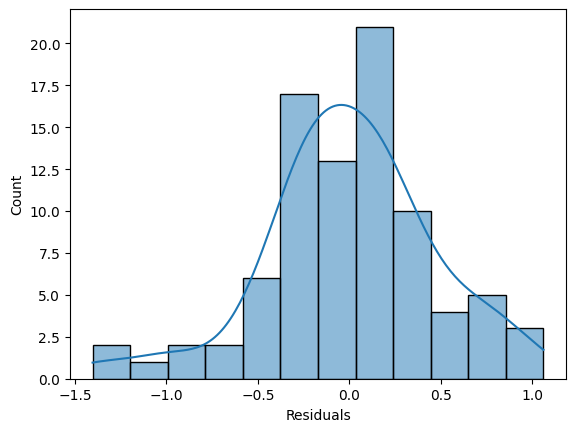

In [58]:
sns.histplot(residuals,kde=True)
plt.xlabel('Residuals')
plt.show()

In [59]:
fitted_values = MLR_model_significant.fittedvalues

In [60]:
print(residuals.shape,fitted_values.shape)

(86,) (86,)


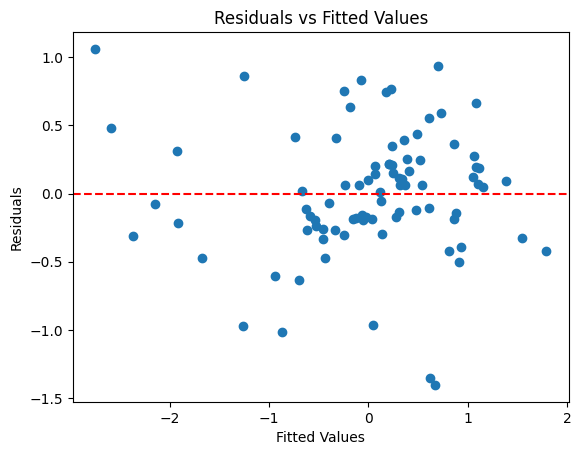

In [61]:
plt.scatter(fitted_values,residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [62]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming X_full has the constant term added
X_full_with_const = sm.add_constant(X_full)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_full_with_const, Y_full, random_state=1, test_size=0.3)

# Fit a multiple linear regression model on the training data
MLR_model = sm.OLS(Y_train, X_train).fit()

# Calculate residuals on the training set
residuals_train = MLR_model.resid

# Add a constant term to X_test
X_test_with_const = sm.add_constant(X_test)

# Calculate residuals on the test set
residuals_test = MLR_model.predict(X_test_with_const) - Y_test

# Perform the Breusch-Pagan test on the residuals of the training set
_, p_value, _, _ = het_breuschpagan(residuals_train, X_train)

# Check p-value and make a conclusion
if p_value < 0.05:
    print('Heteroscedasticity is present (reject the null hypothesis)')
else:
    print('Heteroscedasticity is not present (fail to reject the null hypothesis)')


Heteroscedasticity is present (reject the null hypothesis)


In [63]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

knn_model = GridSearchCV(knn, params, cv=5)
knn_model.fit(X_train_sign,Y_train_sign)
knn_model.best_params_

{'n_neighbors': 3}

In [64]:
y_predict_knn=knn_model.predict(x_test_sign)
KNN_mse=mean_squared_error(y_test_sign,y_predict_knn)
KNN_mae=mean_absolute_error(y_test_sign,y_predict_knn)
r2 = r2_score(y_test_sign, y_predict_knn)

In [65]:
UpdateSummaryTable('KNN significant-features',r2,KNN_mse,KNN_mae)

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332
0,Linear Regression significant-features,0.715642,0.269154,0.394276
0,KNN significant-features,0.718551,0.266401,0.372773


In [141]:
df.columns

Index(['Status', 'Adult_Mortality', 'Infant_Deaths', 'Hepatitis', 'Measles',
       'BMI', 'Underfive_Deaths', 'Polio', 'Diphtheria', 'HIV', 'GDP',
       'Population', 'Malnourished10_19', 'Malnourished5_9', 'Income_Index',
       'Schooling', 'Expected'],
      dtype='object')

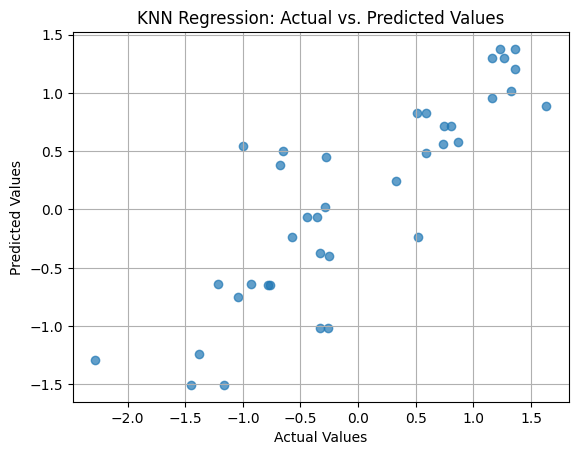

In [150]:
# plt.figure(figsize=(10, 8))
plt.scatter(y_test_sign, y_predict_knn, alpha=0.7)
plt.title('KNN Regression: Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [66]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(X_train_sign,Y_train_sign)

DecisionTreeRegressor(max_depth=5)

In [67]:
y_pred_dtree = regressor.predict(x_test_sign)

In [68]:
mse_Dtree = mean_squared_error(y_test_sign, y_pred_dtree)
mae_Dtree = mean_absolute_error(y_test_sign, y_pred_dtree)
r2_Dtree = r2_score(y_test_sign, y_pred_dtree)

In [69]:
UpdateSummaryTable('Decision significant-features without tuning',r2_Dtree,mse_Dtree,mae_Dtree)

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332
0,Linear Regression significant-features,0.715642,0.269154,0.394276
0,KNN significant-features,0.718551,0.266401,0.372773
0,Decision significant-features without tuning,0.806248,0.183392,0.310820


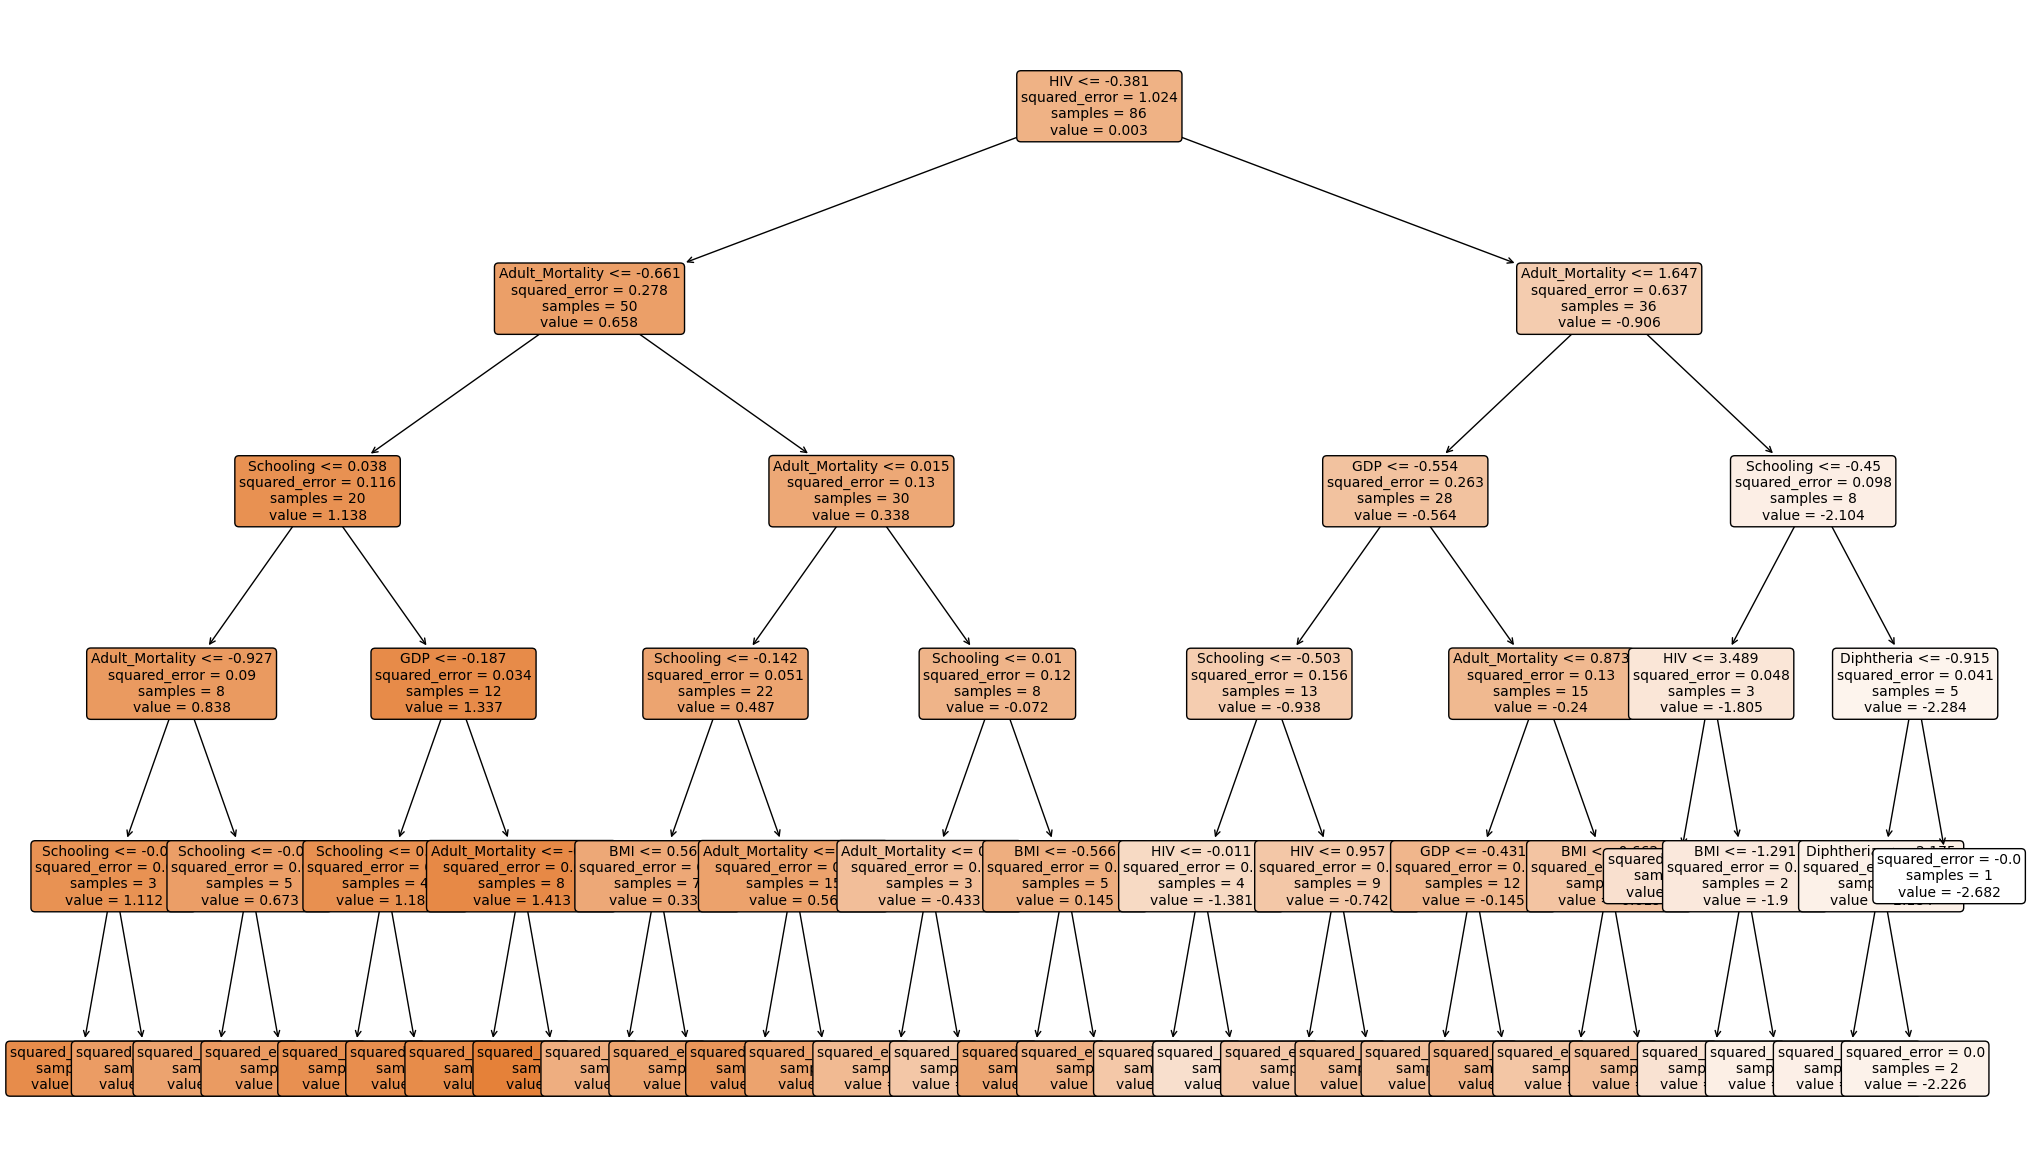

In [70]:
plt.figure(figsize=(25, 15))
plot_tree(regressor, filled=True, feature_names=X_train_sign.columns, rounded=True, fontsize=10)
plt.show()

In [71]:
regressor = DecisionTreeRegressor()
parameter_grid = {
    'max_depth':[None,5,10,15],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
grid_search_model = GridSearchCV(regressor,parameter_grid,cv=5)

In [72]:
grid_search_model.fit(X_train_sign,Y_train_sign)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [73]:
best_params_tree = grid_search_model.best_params_
best_params_tree

{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [74]:
grid_search_model.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_leaf=4)

In [75]:
y_pred_dtree_tuning = grid_search_model.best_estimator_.predict(x_test_sign)

In [76]:
mse_Dtree_tuning = mean_squared_error(y_test_sign, y_pred_dtree_tuning)
mae_Dtree_tuning = mean_absolute_error(y_test_sign, y_pred_dtree_tuning)
r2_Dtree_tuning = r2_score(y_test_sign, y_pred_dtree_tuning)

In [77]:
UpdateSummaryTable('Decision significant-features with hyper parameter tuning',r2_Dtree_tuning,mse_Dtree_tuning,mae_Dtree_tuning)

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332
0,Linear Regression significant-features,0.715642,0.269154,0.394276
0,KNN significant-features,0.718551,0.266401,0.372773
0,Decision significant-features without tuning,0.806248,0.183392,0.310820
0,Decision significant-features with hyper param...,0.790150,0.198630,0.320627


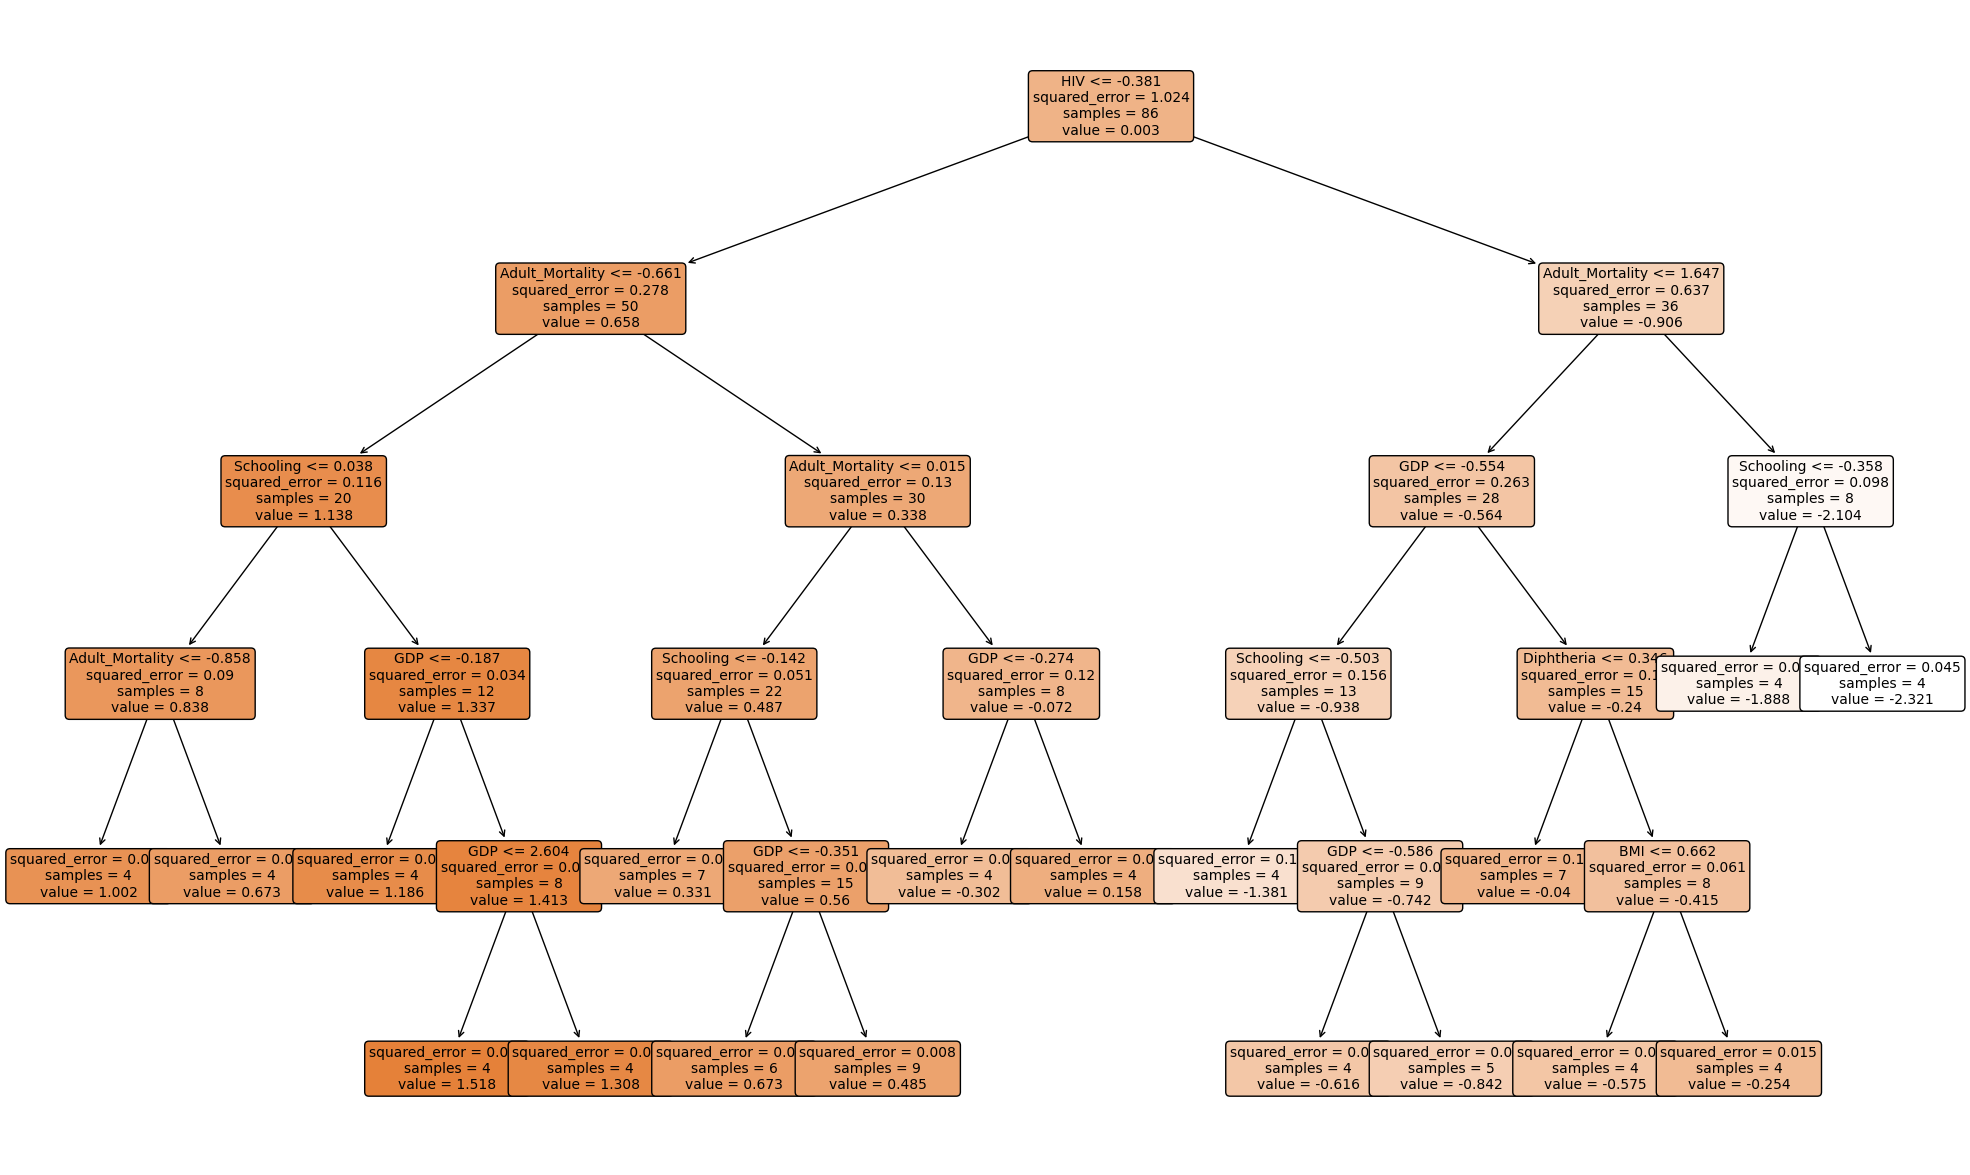

In [78]:
plt.figure(figsize=(25, 15))
plot_tree(grid_search_model.best_estimator_, filled=True, feature_names=X_train_sign.columns, rounded=True, fontsize=10)
plt.show()

In [152]:
model_summary_stats

,Model Name,R2-score,MSE,MAE
0,Linear Regression Full-Features,0.728017,0.257441,0.384332
0,Linear Regression significant-features,0.715642,0.269154,0.394276
0,KNN significant-features,0.718551,0.266401,0.372773
0,Decision significant-features without tuning,0.806248,0.183392,0.310820
0,Decision significant-features with hyper param...,0.790150,0.198630,0.320627


# Model Selection:
- In summary, the Decision Tree model, particularly without hyperparameter tuning, showcases superior predictive power on our dataset, achieving a balance between accuracy and interpretability. Further exploration may involve fine-tuning hyperparameters for optimal performance and robustness in real-world applications